In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
import scipy
import os
from scipy.stats import linregress
from datetime import timedelta

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

warnings.filterwarnings("ignore")

from isofit.inversion.inverse_simple import invert_liquid_water

from isofit.core.common import (
    get_refractive_index,
)

plt.rcParams['figure.dpi'] = 300

## 1. Load in and organize data

In [2]:
fielddata_path = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/field_data/LWC_LFM_WP_dates20230525.csv'

cwc_dir_850_1300 = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/cwc_850_1300'
cwc_dir_850_1100 = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/cwc_850_1100'
cwc_dir_1100_1300 = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/cwc_1100_1300'

In [3]:
## reading in and organizing field data
fielddata = pd.read_csv(fielddata_path)
lwp = fielddata[['tree','time','species','date_wp','mpa_mean']] \
        .dropna().drop_duplicates().reset_index(drop=True)
lwp['datetime_wp'] = lwp.apply(lambda x: datetime.strptime(str(x['date_wp']),'%Y-%m-%d'), axis=1)

lwa = fielddata[['tree','time','species','date_wp','lwa_g_cm2']] \
        .dropna().drop_duplicates().reset_index(drop=True)
lwa['datetime_wp'] = lwa.apply(lambda x: datetime.strptime(str(x['date_wp']),'%Y-%m-%d'), axis=1)

lwc = fielddata[['tree','time','species','date_wp','lwc_mean']] \
        .dropna().drop_duplicates().reset_index(drop=True)
lwc['datetime_wp'] = lwc.apply(lambda x: datetime.strptime(str(x['date_wp']),'%Y-%m-%d'), axis=1)

In [4]:
## reading in and organizing CWC data

# date_list = ['20220224', '20220228',  '20220308', '20220316', '20220322', '20220405', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529', '20220914']
date_list = ['20220429', '20220503', '20220511', '20220517', '20220529', '20220914']
datetime_list = [datetime.strptime(date, '%Y%m%d') for date in date_list]

# handling for non-convergence in the invert_liquid_water function
def kill_nans(df):
    mask = (df['CWC'] > 0.499962 - 0.0001) & (df['CWC'] < 0.499962 + 0.0001)
    df.loc[mask, 'CWC'] = np.nan
    return df

## first the full baloney of 850-1300nm
cwc_file_paths_850_1300 = [os.path.join(cwc_dir_850_1300, date + '_cwc.csv') for date in date_list]
# read in one file just to get the tree numbers
cwc_850_1300 = pd.read_csv(cwc_file_paths_850_1300[0]).set_index('Tree Number').drop(columns=['MAE', 'Intercept', 'Slope']).rename(columns={'CWC': 'CWC_' + date_list[0]})
for date, file_path in zip(date_list[1:], cwc_file_paths_850_1300[1:]):
    other_df = pd.read_csv(file_path).set_index('Tree Number')
    cwc_850_1300 = cwc_850_1300.join(other_df['CWC']).rename(columns={'CWC': 'CWC_' + date})
# now make a list of dataframes containing all the good stuff
cwc_df_list_850_1300 = []
for date, file_path in zip(date_list, cwc_file_paths_850_1300):
    cwc_df = pd.read_csv(file_path)
    cwc_df['datetime'] = datetime.strptime(date, '%Y%m%d')
    cwc_df = kill_nans(cwc_df)
    cwc_df_list_850_1300.append(cwc_df)


## now the 850-1100nm...
cwc_file_paths_850_1100 = [os.path.join(cwc_dir_850_1100, date + '_cwc.csv') for date in date_list]
# read in one file just to get the tree numbers
cwc_850_1100 = pd.read_csv(cwc_file_paths_850_1100[0]).set_index('Tree Number').drop(columns=['MAE', 'Intercept', 'Slope']).rename(columns={'CWC': 'CWC_' + date_list[0]})
for date, file_path in zip(date_list[1:], cwc_file_paths_850_1100[1:]):
    other_df = pd.read_csv(file_path).set_index('Tree Number')
    cwc_850_1100 = cwc_850_1100.join(other_df['CWC']).rename(columns={'CWC': 'CWC_' + date})
# now make a list of dataframes containing all the good stuff
cwc_df_list_850_1100 = []
for date, file_path in zip(date_list, cwc_file_paths_850_1100):
    cwc_df = pd.read_csv(file_path)
    cwc_df['datetime'] = datetime.strptime(date, '%Y%m%d')
    cwc_df = kill_nans(cwc_df)
    cwc_df_list_850_1100.append(cwc_df)


## finally the 1100-1300nm region
cwc_file_paths_1100_1300 = [os.path.join(cwc_dir_1100_1300, date + '_cwc.csv') for date in date_list]
# read in one file just to get the tree numbers
cwc_1100_1300 = pd.read_csv(cwc_file_paths_1100_1300[0]).set_index('Tree Number').drop(columns=['MAE', 'Intercept', 'Slope']).rename(columns={'CWC': 'CWC_' + date_list[0]})
for date, file_path in zip(date_list[1:], cwc_file_paths_1100_1300[1:]):
    other_df = pd.read_csv(file_path).set_index('Tree Number')
    cwc_1100_1300 = cwc_1100_1300.join(other_df['CWC']).rename(columns={'CWC': 'CWC_' + date})
# now make a list of dataframes containing all the good stuff
cwc_df_list_1100_1300 = []
for date, file_path in zip(date_list, cwc_file_paths_1100_1300):
    cwc_df = pd.read_csv(file_path)
    cwc_df['datetime'] = datetime.strptime(date, '%Y%m%d')
    cwc_df = kill_nans(cwc_df)
    cwc_df_list_1100_1300.append(cwc_df)

In [5]:
# Defining color cycle to correspond with dates, extended a lil to account for more dates
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_list.append('#000080')
color_list.append('#420303')
color_list.append('#018788')

## 2. Joining CWC and Field Data

In [6]:
## function to hunt down the MD LWP for a given tree and date
def get_midday_lwp(thisTree, imgdate):
    try:
        ourTree = int(thisTree)
    except:
        return np.NaN # specific handling for uncertainty in tree number (whoops)
    lowerDateBound = imgdate + timedelta(days=-3)
    upperDateBound = imgdate + timedelta(days=3)
    filtered = lwp[(lwp['tree']==int(thisTree)) & (lwp['time']=='md') & (lwp['datetime_wp']<=upperDateBound) & (lwp['datetime_wp']>=lowerDateBound)]
    return filtered['mpa_mean'].mean()

## function to hunt down the PD LWP for a given tree and date
def get_predawn_lwp(thisTree, imgdate):
    try:
        ourTree = int(thisTree)
    except:
        return np.NaN
    lowerDateBound = imgdate + timedelta(days=-8)
    upperDateBound = imgdate + timedelta(days=8)
    filtered = lwp[(lwp['tree']==int(thisTree)) & (lwp['time']=='pd') & (lwp['datetime_wp']<=upperDateBound) & (lwp['datetime_wp']>=lowerDateBound)]
    return filtered['mpa_mean'].mean()

## function to hunt down the MD LWC for a given tree and date
def get_midday_lwc(thisTree, imgdate):
    try:
        ourTree = int(thisTree)
    except:
        return np.NaN
    lowerDateBound = imgdate + timedelta(days=-3)
    upperDateBound = imgdate + timedelta(days=3)
    filtered = lwc[(lwc['tree']==int(thisTree)) & (lwc['time']=='md') & (lwc['datetime_wp']<=upperDateBound) & (lwc['datetime_wp']>=lowerDateBound)]
    return filtered['lwc_mean'].mean()

In [7]:
## append the LWP and LWC data to the CWC dataframes to make things easier later
for cwc_df in cwc_df_list_850_1300:
    cwc_df['midday_lwp'] = cwc_df.apply(lambda x: get_midday_lwp(x['Tree Number'], x['datetime']), axis=1)
    cwc_df['predawn_lwp'] = cwc_df.apply(lambda x: get_predawn_lwp(x['Tree Number'], x['datetime']), axis=1)
    cwc_df['midday_lwc'] = cwc_df.apply(lambda x: get_midday_lwc(x['Tree Number'], x['datetime']), axis=1)

for cwc_df in cwc_df_list_850_1100:
    cwc_df['midday_lwp'] = cwc_df.apply(lambda x: get_midday_lwp(x['Tree Number'], x['datetime']), axis=1)
    cwc_df['predawn_lwp'] = cwc_df.apply(lambda x: get_predawn_lwp(x['Tree Number'], x['datetime']), axis=1)
    cwc_df['midday_lwc'] = cwc_df.apply(lambda x: get_midday_lwc(x['Tree Number'], x['datetime']), axis=1)

for cwc_df in cwc_df_list_1100_1300:
    cwc_df['midday_lwp'] = cwc_df.apply(lambda x: get_midday_lwp(x['Tree Number'], x['datetime']), axis=1)
    cwc_df['predawn_lwp'] = cwc_df.apply(lambda x: get_predawn_lwp(x['Tree Number'], x['datetime']), axis=1)
    cwc_df['midday_lwc'] = cwc_df.apply(lambda x: get_midday_lwc(x['Tree Number'], x['datetime']), axis=1)

## 3. Plot CWC vs LWP & LWC for All Three Wavelength Ranges

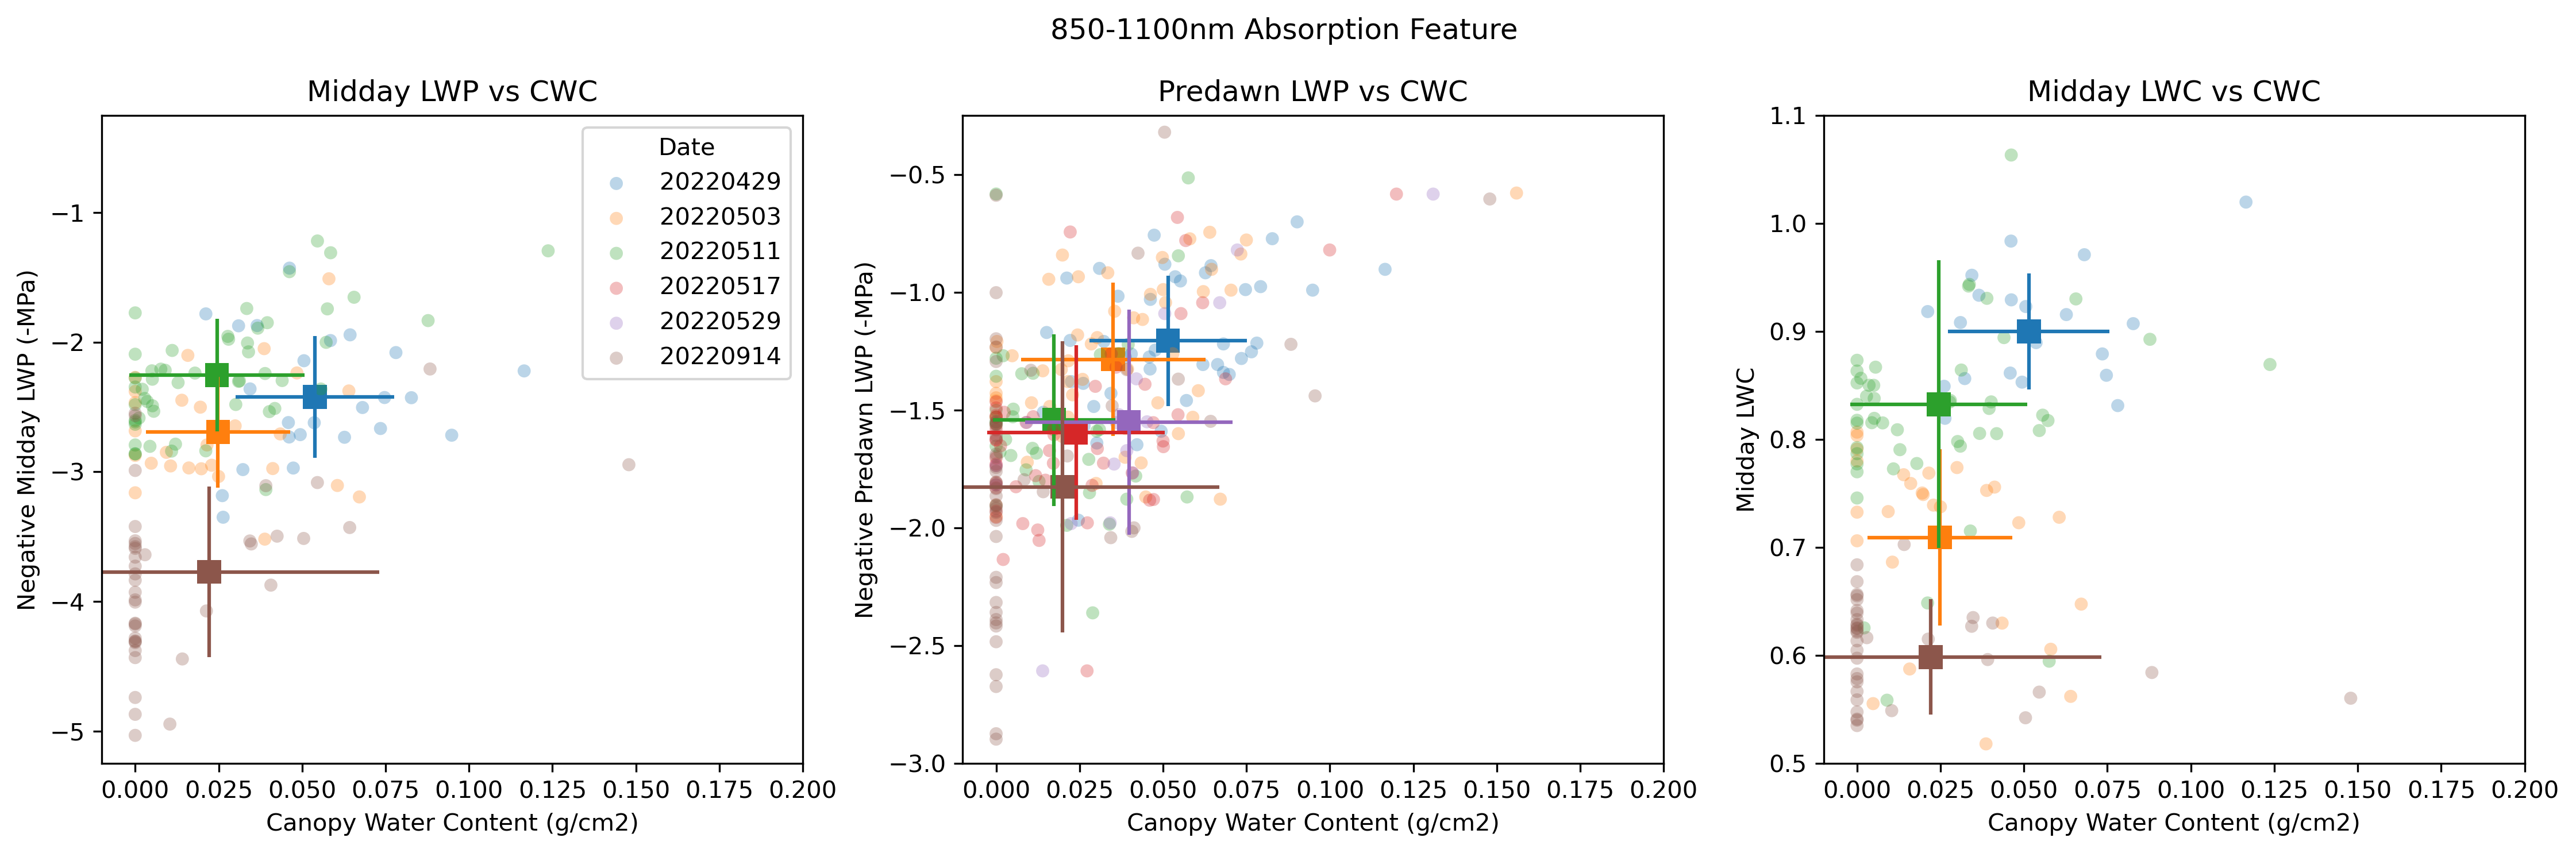

In [8]:
# first absorption feature (850-1100)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

for date, cwc_df, color in zip(date_list, cwc_df_list_850_1100, color_list):
    cwc_df_dropna_mdlwp = cwc_df.dropna(subset=['midday_lwp', 'CWC'])
    avg_cwc_mdlwp = cwc_df_dropna_mdlwp['CWC'].mean()
    avg_midday_lwp = cwc_df_dropna_mdlwp['midday_lwp'].mean()
    std_cwc_mdlwp = cwc_df_dropna_mdlwp['CWC'].std()
    std_midday_lwp = cwc_df_dropna_mdlwp['midday_lwp'].std()

    cwc_df_dropna_pdlwp = cwc_df.dropna(subset=['predawn_lwp', 'CWC'])
    avg_cwc_pdlwp = cwc_df_dropna_pdlwp['CWC'].mean()
    avg_predawn_lwp = cwc_df_dropna_pdlwp['predawn_lwp'].mean()
    std_cwc_pdlwp = cwc_df_dropna_pdlwp['CWC'].std()
    std_predawn_lwp = cwc_df_dropna_pdlwp['predawn_lwp'].std()

    cwc_df_dropna_lwc = cwc_df.dropna(subset=['midday_lwc', 'CWC'])
    avg_cwc_lwc = cwc_df_dropna_lwc['CWC'].mean()
    avg_midday_lwc = cwc_df_dropna_lwc['midday_lwc'].mean()
    std_cwc_lwc = cwc_df_dropna_lwc['CWC'].std()
    std_midday_lwc = cwc_df_dropna_lwc['midday_lwc'].std()

    ax1.scatter(cwc_df['CWC'], -1*cwc_df['midday_lwp'], c=color, edgecolors='none', s=30, alpha=0.3, label=date)
    ax1.scatter(avg_cwc_mdlwp, -1*avg_midday_lwp, c=color, edgecolors='none', s=100, alpha=1, marker='s')
    ax1.errorbar(avg_cwc_mdlwp, -1*avg_midday_lwp, yerr=std_midday_lwp, fmt='none', ecolor=color)
    ax1.errorbar(avg_cwc_mdlwp, -1*avg_midday_lwp, xerr=std_cwc_mdlwp, fmt='none', ecolor=color)

    ax2.scatter(cwc_df['CWC'], -1*cwc_df['predawn_lwp'], c=color, edgecolors='none', s=30, alpha=0.3, label=date)
    ax2.scatter(avg_cwc_pdlwp, -1*avg_predawn_lwp, c=color, edgecolors='none', s=100, alpha=1, marker='s')
    ax2.errorbar(avg_cwc_pdlwp, -1*avg_predawn_lwp, yerr=std_predawn_lwp, fmt='none', ecolor=color)
    ax2.errorbar(avg_cwc_pdlwp, -1*avg_predawn_lwp, xerr=std_cwc_pdlwp, fmt='none', ecolor=color)

    ax3.scatter(cwc_df['CWC'], cwc_df['midday_lwc'], c=color, edgecolors='none', s=30, alpha=0.3, label=date)
    ax3.scatter(avg_cwc_lwc, avg_midday_lwc, c=color, edgecolors='none', s=100, alpha=1, marker='s')
    ax3.errorbar(avg_cwc_lwc, avg_midday_lwc, yerr=std_midday_lwc, fmt='none', ecolor=color)
    ax3.errorbar(avg_cwc_lwc, avg_midday_lwc, xerr=std_cwc_lwc, fmt='none', ecolor=color)

fig.suptitle('850-1100nm Absorption Feature')

ax1.set_ylabel('Negative Midday LWP (-MPa)')
ax1.set_xlabel('Canopy Water Content (g/cm2)')
ax1.set_title('Midday LWP vs CWC')
ax1.set_xlim(-0.01, 0.2)
ax1.set_ylim(-5.25, -0.25)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, title='Date', loc='upper right')


ax2.set_ylabel('Negative Predawn LWP (-MPa)')
ax2.set_xlabel('Canopy Water Content (g/cm2)')
ax2.set_title('Predawn LWP vs CWC')
ax2.set_xlim(-0.01, 0.2)
ax2.set_ylim(-3, -0.25)

ax3.set_ylabel('Midday LWC')
ax3.set_xlabel('Canopy Water Content (g/cm2)')
ax3.set_title('Midday LWC vs CWC')
ax3.set_xlim(-0.01, 0.2)
ax3.set_ylim(0.5, 1.1)

plt.tight_layout()
plt.show()

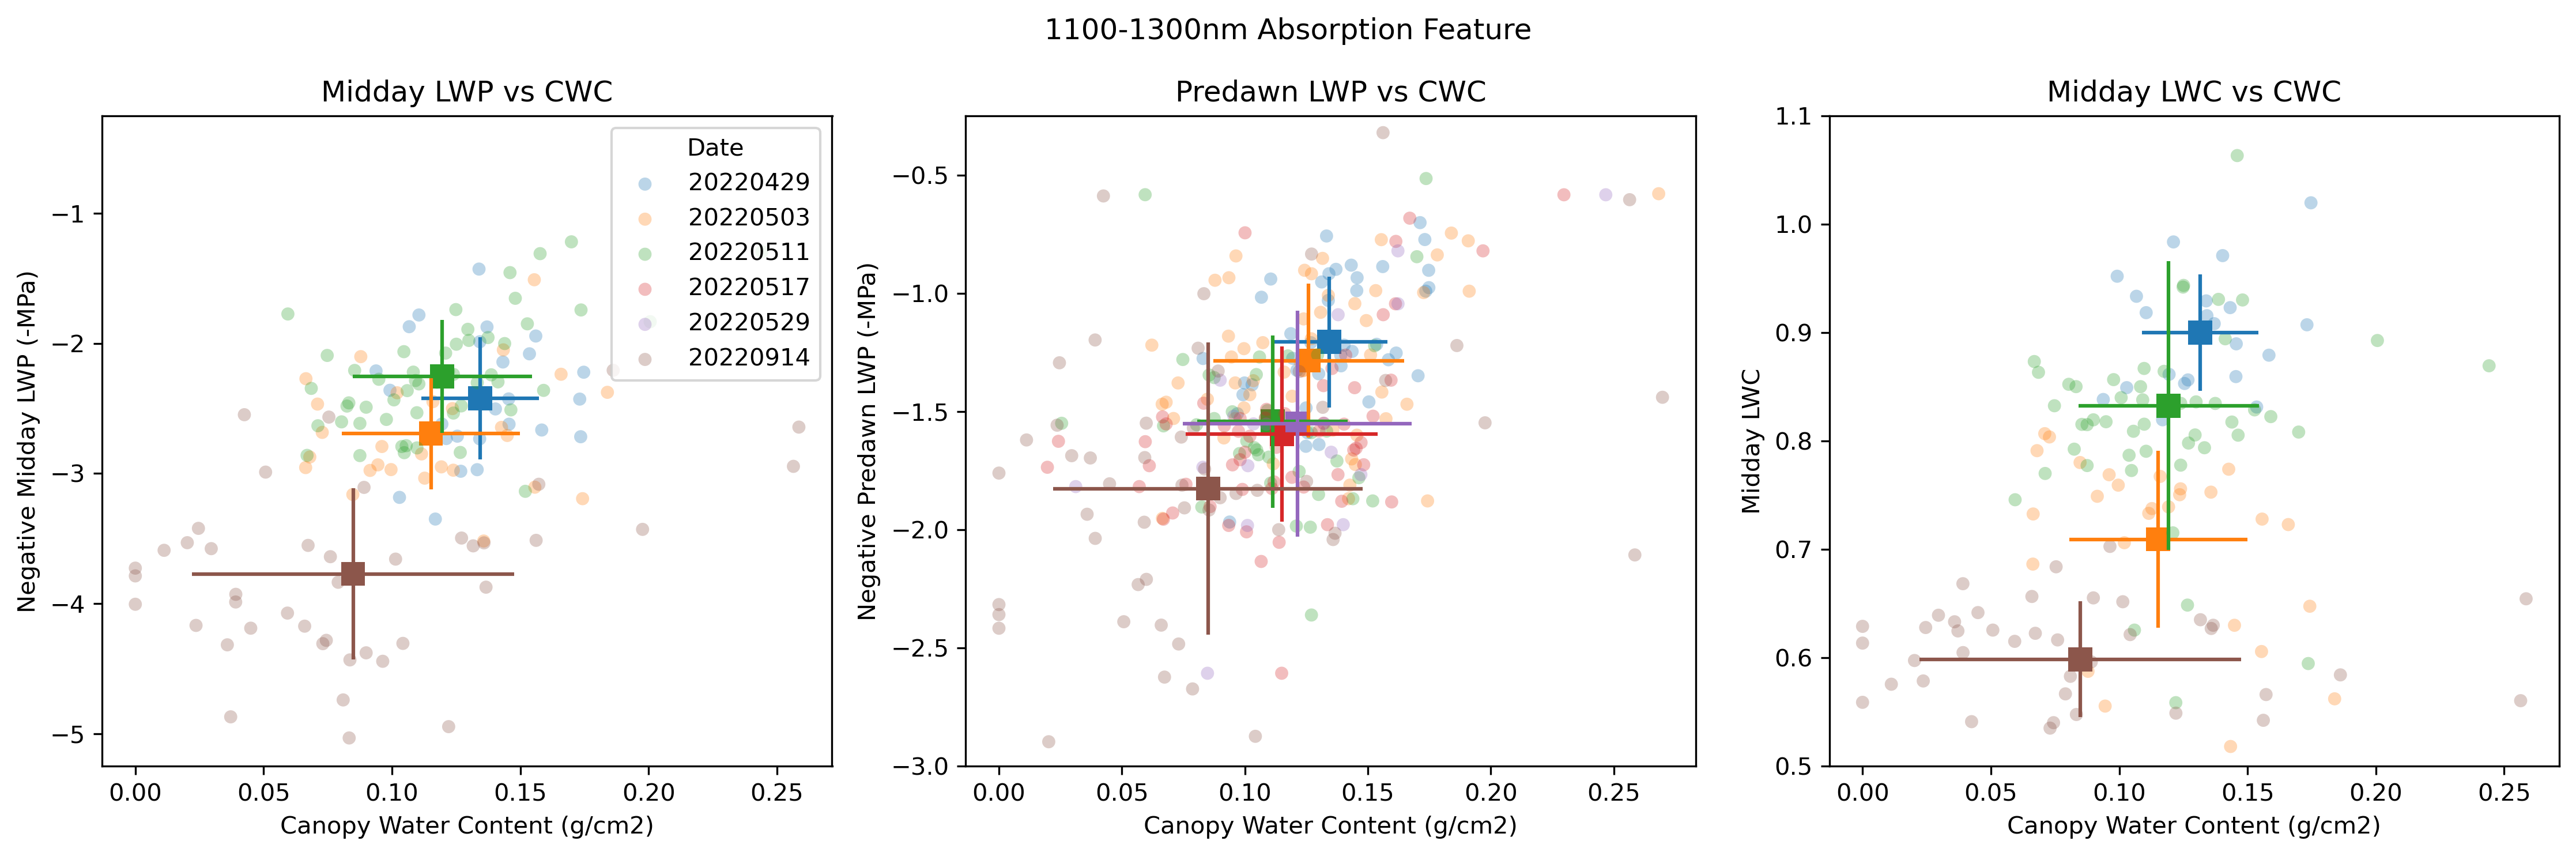

In [9]:
# second absorption feature (1100-1300)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

for date, cwc_df, color in zip(date_list, cwc_df_list_1100_1300, color_list):
    cwc_df_dropna_mdlwp = cwc_df.dropna(subset=['midday_lwp', 'CWC'])
    avg_cwc_mdlwp = cwc_df_dropna_mdlwp['CWC'].mean()
    avg_midday_lwp = cwc_df_dropna_mdlwp['midday_lwp'].mean()
    std_cwc_mdlwp = cwc_df_dropna_mdlwp['CWC'].std()
    std_midday_lwp = cwc_df_dropna_mdlwp['midday_lwp'].std()

    cwc_df_dropna_pdlwp = cwc_df.dropna(subset=['predawn_lwp', 'CWC'])
    avg_cwc_pdlwp = cwc_df_dropna_pdlwp['CWC'].mean()
    avg_predawn_lwp = cwc_df_dropna_pdlwp['predawn_lwp'].mean()
    std_cwc_pdlwp = cwc_df_dropna_pdlwp['CWC'].std()
    std_predawn_lwp = cwc_df_dropna_pdlwp['predawn_lwp'].std()

    cwc_df_dropna_lwc = cwc_df.dropna(subset=['midday_lwc', 'CWC'])
    avg_cwc_lwc = cwc_df_dropna_lwc['CWC'].mean()
    avg_midday_lwc = cwc_df_dropna_lwc['midday_lwc'].mean()
    std_cwc_lwc = cwc_df_dropna_lwc['CWC'].std()
    std_midday_lwc = cwc_df_dropna_lwc['midday_lwc'].std()

    ax1.scatter(cwc_df['CWC'], -1*cwc_df['midday_lwp'], c=color, edgecolors='none', s=30, alpha=0.3, label=date)
    ax1.scatter(avg_cwc_mdlwp, -1*avg_midday_lwp, c=color, edgecolors='none', s=100, alpha=1, marker='s')
    ax1.errorbar(avg_cwc_mdlwp, -1*avg_midday_lwp, yerr=std_midday_lwp, fmt='none', ecolor=color)
    ax1.errorbar(avg_cwc_mdlwp, -1*avg_midday_lwp, xerr=std_cwc_mdlwp, fmt='none', ecolor=color)

    ax2.scatter(cwc_df['CWC'], -1*cwc_df['predawn_lwp'], c=color, edgecolors='none', s=30, alpha=0.3, label=date)
    ax2.scatter(avg_cwc_pdlwp, -1*avg_predawn_lwp, c=color, edgecolors='none', s=100, alpha=1, marker='s')
    ax2.errorbar(avg_cwc_pdlwp, -1*avg_predawn_lwp, yerr=std_predawn_lwp, fmt='none', ecolor=color)
    ax2.errorbar(avg_cwc_pdlwp, -1*avg_predawn_lwp, xerr=std_cwc_pdlwp, fmt='none', ecolor=color)

    ax3.scatter(cwc_df['CWC'], cwc_df['midday_lwc'], c=color, edgecolors='none', s=30, alpha=0.3, label=date)
    ax3.scatter(avg_cwc_lwc, avg_midday_lwc, c=color, edgecolors='none', s=100, alpha=1, marker='s')
    ax3.errorbar(avg_cwc_lwc, avg_midday_lwc, yerr=std_midday_lwc, fmt='none', ecolor=color)
    ax3.errorbar(avg_cwc_lwc, avg_midday_lwc, xerr=std_cwc_lwc, fmt='none', ecolor=color)

fig.suptitle('1100-1300nm Absorption Feature')

ax1.set_ylabel('Negative Midday LWP (-MPa)')
ax1.set_xlabel('Canopy Water Content (g/cm2)')
ax1.set_title('Midday LWP vs CWC')
# ax1.set_xlim(-0.01, 0.2)
ax1.set_ylim(-5.25, -0.25)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, title='Date', loc='upper right')

ax2.set_ylabel('Negative Predawn LWP (-MPa)')
ax2.set_xlabel('Canopy Water Content (g/cm2)')
ax2.set_title('Predawn LWP vs CWC')
# ax2.set_xlim(-0.01, 0.2)
ax2.set_ylim(-3, -0.25)

ax3.set_ylabel('Midday LWC')
ax3.set_xlabel('Canopy Water Content (g/cm2)')
ax3.set_title('Midday LWC vs CWC')
# ax3.set_xlim(-0.01, 0.2)
ax3.set_ylim(0.5, 1.1)

plt.tight_layout()
plt.show()

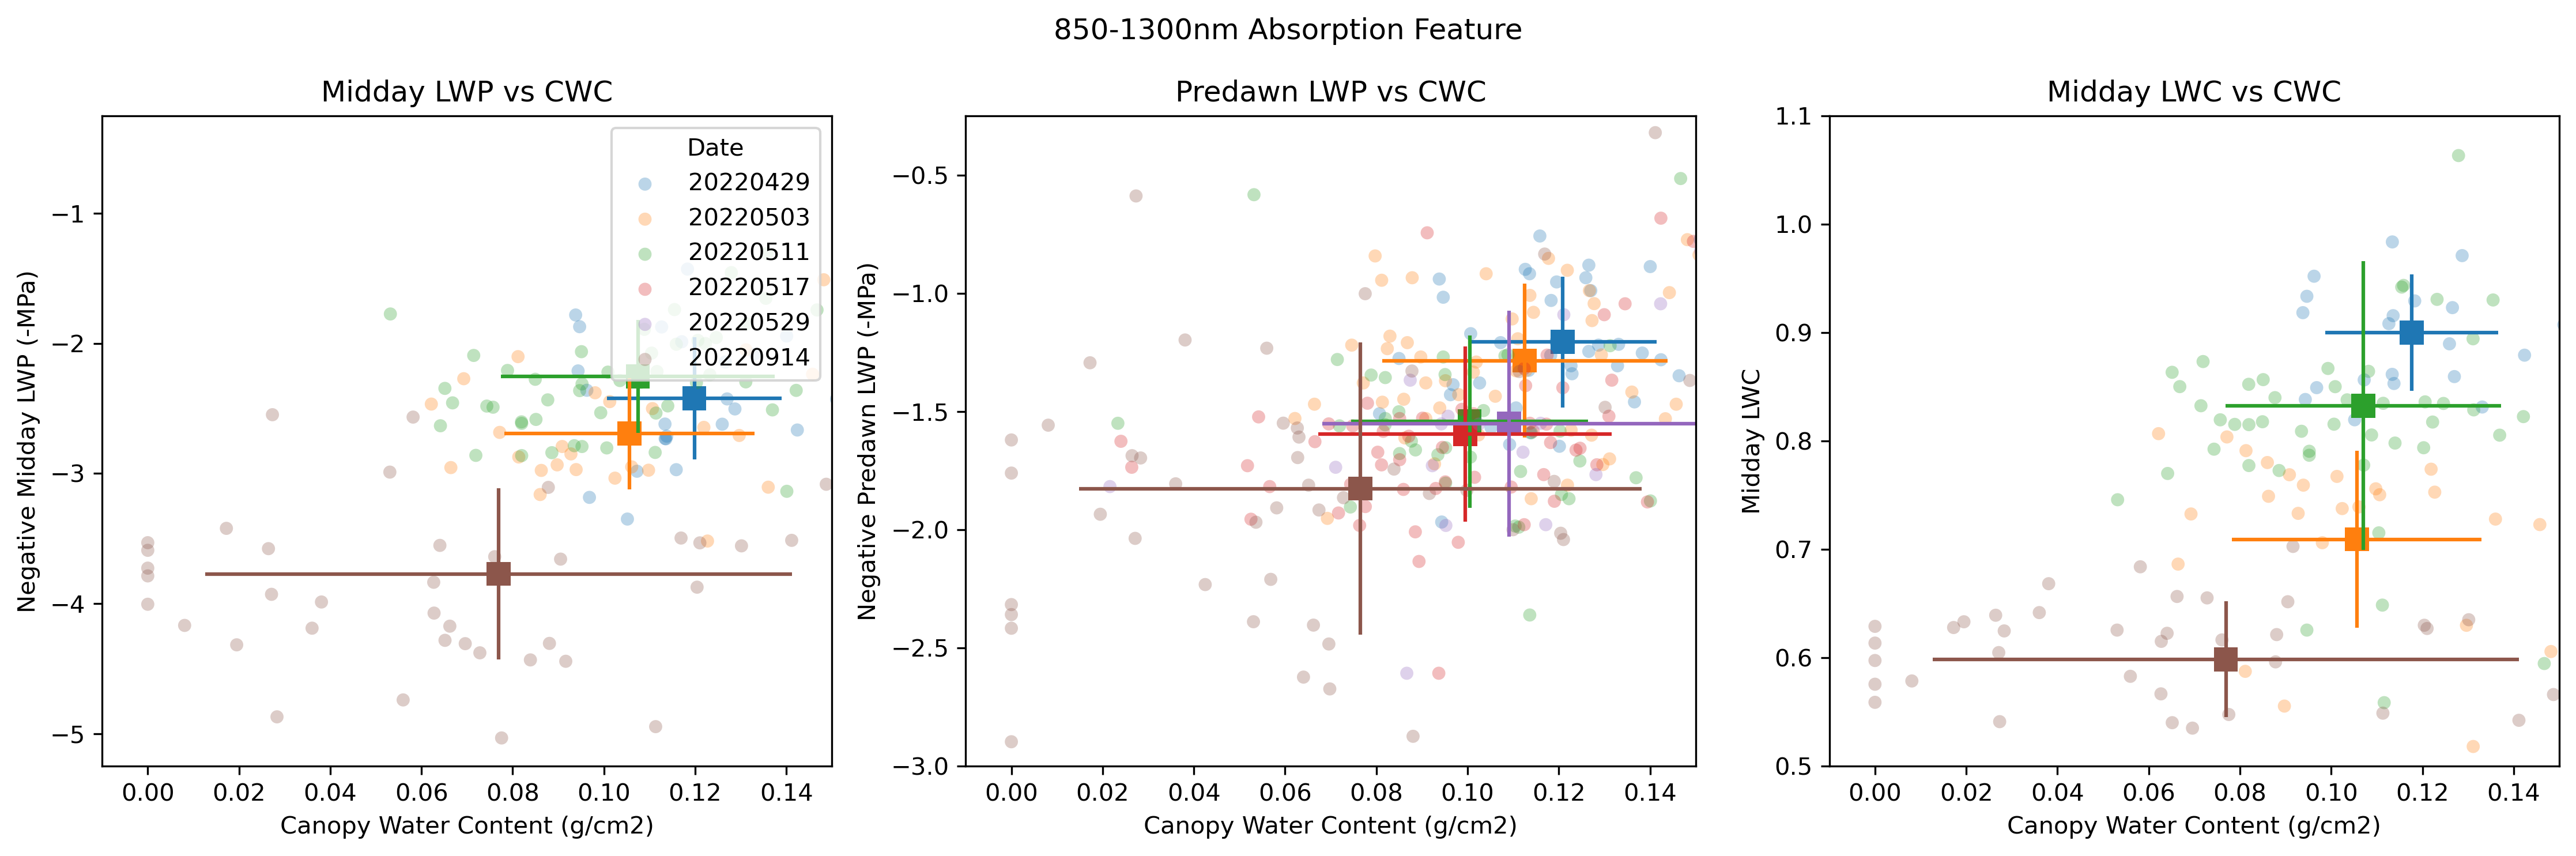

In [10]:
# combined absorption features (850-1300)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

for date, cwc_df, color in zip(date_list, cwc_df_list_850_1300, color_list):
    cwc_df_dropna_mdlwp = cwc_df.dropna(subset=['midday_lwp', 'CWC'])
    avg_cwc_mdlwp = cwc_df_dropna_mdlwp['CWC'].mean()
    avg_midday_lwp = cwc_df_dropna_mdlwp['midday_lwp'].mean()
    std_cwc_mdlwp = cwc_df_dropna_mdlwp['CWC'].std()
    std_midday_lwp = cwc_df_dropna_mdlwp['midday_lwp'].std()

    cwc_df_dropna_pdlwp = cwc_df.dropna(subset=['predawn_lwp', 'CWC'])
    avg_cwc_pdlwp = cwc_df_dropna_pdlwp['CWC'].mean()
    avg_predawn_lwp = cwc_df_dropna_pdlwp['predawn_lwp'].mean()
    std_cwc_pdlwp = cwc_df_dropna_pdlwp['CWC'].std()
    std_predawn_lwp = cwc_df_dropna_pdlwp['predawn_lwp'].std()

    cwc_df_dropna_lwc = cwc_df.dropna(subset=['midday_lwc', 'CWC'])
    avg_cwc_lwc = cwc_df_dropna_lwc['CWC'].mean()
    avg_midday_lwc = cwc_df_dropna_lwc['midday_lwc'].mean()
    std_cwc_lwc = cwc_df_dropna_lwc['CWC'].std()
    std_midday_lwc = cwc_df_dropna_lwc['midday_lwc'].std()

    ax1.scatter(cwc_df['CWC'], -1*cwc_df['midday_lwp'], c=color, edgecolors='none', s=30, alpha=0.3, label=date)
    ax1.scatter(avg_cwc_mdlwp, -1*avg_midday_lwp, c=color, edgecolors='none', s=100, alpha=1, marker='s')
    ax1.errorbar(avg_cwc_mdlwp, -1*avg_midday_lwp, yerr=std_midday_lwp, fmt='none', ecolor=color)
    ax1.errorbar(avg_cwc_mdlwp, -1*avg_midday_lwp, xerr=std_cwc_mdlwp, fmt='none', ecolor=color)

    ax2.scatter(cwc_df['CWC'], -1*cwc_df['predawn_lwp'], c=color, edgecolors='none', s=30, alpha=0.3, label=date)
    ax2.scatter(avg_cwc_pdlwp, -1*avg_predawn_lwp, c=color, edgecolors='none', s=100, alpha=1, marker='s')
    ax2.errorbar(avg_cwc_pdlwp, -1*avg_predawn_lwp, yerr=std_predawn_lwp, fmt='none', ecolor=color)
    ax2.errorbar(avg_cwc_pdlwp, -1*avg_predawn_lwp, xerr=std_cwc_pdlwp, fmt='none', ecolor=color)

    ax3.scatter(cwc_df['CWC'], cwc_df['midday_lwc'], c=color, edgecolors='none', s=30, alpha=0.3, label=date)
    ax3.scatter(avg_cwc_lwc, avg_midday_lwc, c=color, edgecolors='none', s=100, alpha=1, marker='s')
    ax3.errorbar(avg_cwc_lwc, avg_midday_lwc, yerr=std_midday_lwc, fmt='none', ecolor=color)
    ax3.errorbar(avg_cwc_lwc, avg_midday_lwc, xerr=std_cwc_lwc, fmt='none', ecolor=color)

fig.suptitle('850-1300nm Absorption Feature')

ax1.set_ylabel('Negative Midday LWP (-MPa)')
ax1.set_xlabel('Canopy Water Content (g/cm2)')
ax1.set_title('Midday LWP vs CWC')
ax1.set_xlim(-0.01, 0.15)
ax1.set_ylim(-5.25, -0.25)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, title='Date', loc='upper right')

ax2.set_ylabel('Negative Predawn LWP (-MPa)')
ax2.set_xlabel('Canopy Water Content (g/cm2)')
ax2.set_title('Predawn LWP vs CWC')
ax2.set_xlim(-0.01, 0.15)
ax2.set_ylim(-3, -0.25)

ax3.set_ylabel('Midday LWC')
ax3.set_xlabel('Canopy Water Content (g/cm2)')
ax3.set_title('Midday LWC vs CWC')
ax3.set_xlim(-0.01, 0.15)
ax3.set_ylim(0.5, 1.1)

plt.tight_layout()
plt.show()

## 4. Demonstrating Wavelength Ranges

In [11]:
def beer_lambert_propagation(wl, alpha_lw, cwc, intercept, slope):
    # wl: wavelengths
    # alpha_lw: liquid water absorption coefficient
    # cwc: canopy water content returned by invert_liquid_water
    # intercept: intercept of the linear fit returned by invert_liquid_water
    # slope: slope of the linear fit returned by invert_liquid_water
    
    attenuation = np.exp(-cwc * 1e7 * alpha_lw)
    return (intercept + slope * wl) * attenuation

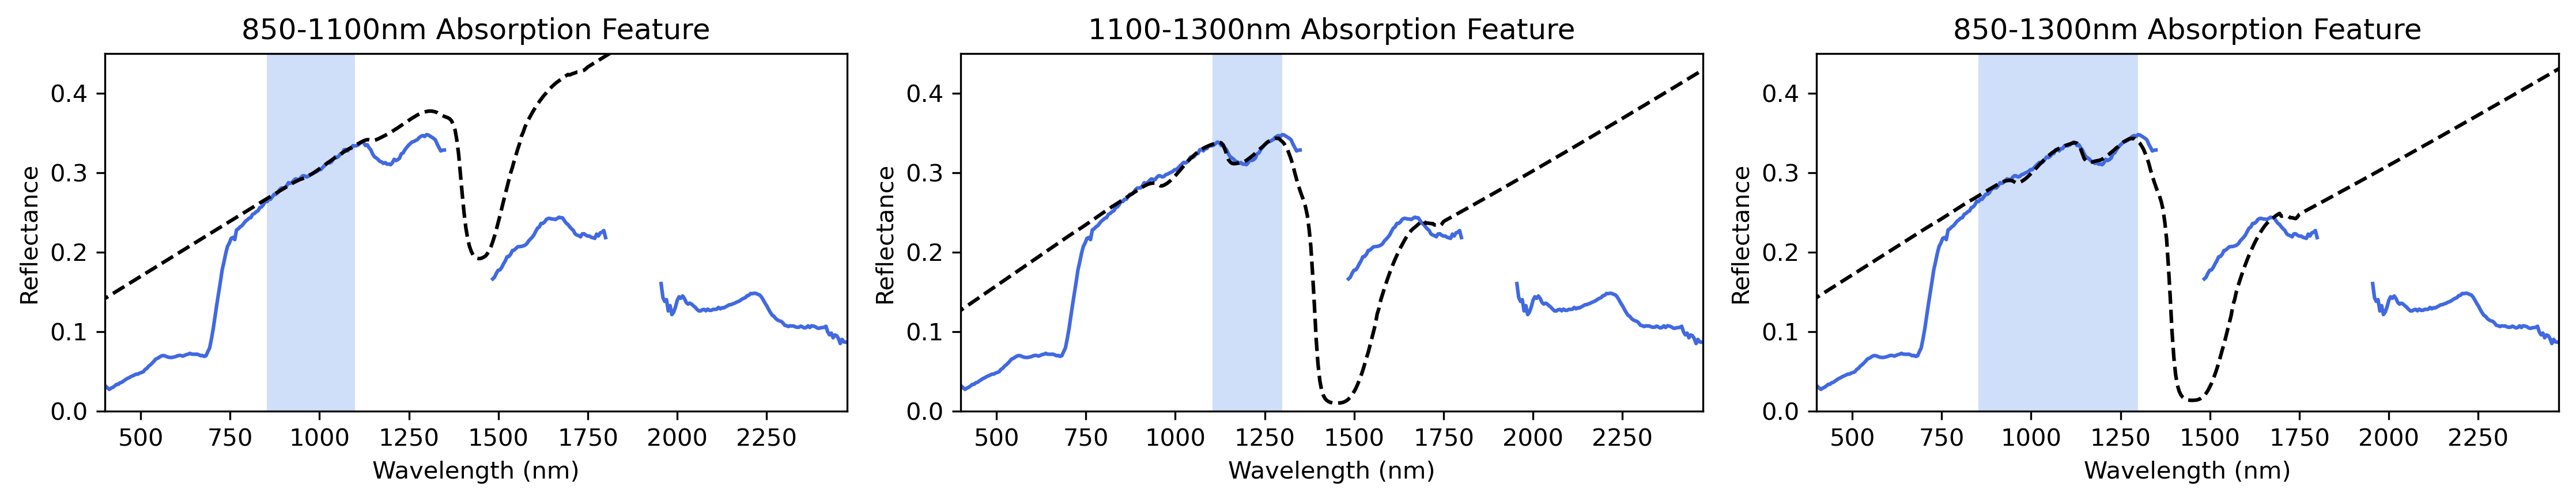

In [12]:
## load up a random spec
spec_file_path = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/extracted_spectra_by_tree/20220511_tree_spectra.csv'
spec_file = pd.read_csv(spec_file_path, index_col='Unnamed: 0')
wavelengths = np.array(spec_file.index)
wl_nan = wavelengths.copy()
wl_nan[wavelengths < 400] = np.nan 
wl_nan[wavelengths > 2475] = np.nan 
wl_nan[np.logical_and(wavelengths > 1350, wavelengths < 1480)] = np.nan 
wl_nan[np.logical_and(wavelengths > 1800, wavelengths < 1950)] = np.nan 
i = 18
spec = np.array(spec_file.iloc[:, i])

# load up water absorption data
isofit_path = 'C:/Users/jeanallen/MiniConda3/envs/rs/Lib/site-packages'  ## may vary for other users
path_k = os.path.join(isofit_path, "data", "iop", "k_liquid_water_ice.xlsx")
k_wi = pd.read_excel(io=path_k, sheet_name="Sheet1", engine="openpyxl")
wl_water, k_water = get_refractive_index(k_wi=k_wi, a=0, b=982, col_wvl="wvl_6", col_k="T = 20°C")
kw = np.interp(x=wavelengths, xp=wl_water, fp=k_water)
abs_co_w = 4 * np.pi * kw / wavelengths
alpha_lw = abs_co_w

# beer-lambert
left_bound1 = 850
right_bound1 = 1100
cwc1, intercept1, slope1 = invert_liquid_water(np.array(spec_file.iloc[:, i]), wavelengths, l_shoulder=left_bound1, r_shoulder=right_bound1)
beer_lambert1 = beer_lambert_propagation(wavelengths, alpha_lw, cwc1, intercept1, slope1)
left_bound2 = 1100
right_bound2 = 1300
cwc2, intercept2, slope2 = invert_liquid_water(np.array(spec_file.iloc[:, i]), wavelengths, l_shoulder=left_bound2, r_shoulder=right_bound2)
beer_lambert2 = beer_lambert_propagation(wavelengths, alpha_lw, cwc2, intercept2, slope2)
left_bound3 = 850
right_bound3 = 1300
cwc3, intercept3, slope3 = invert_liquid_water(np.array(spec_file.iloc[:, i]), wavelengths, l_shoulder=left_bound3, r_shoulder=right_bound3)
beer_lambert3 = beer_lambert_propagation(wavelengths, alpha_lw, cwc3, intercept3, slope3)


# plot...
fig, (spec1, spec2, spec3) = plt.subplots(1, 3, figsize=(15, 3))

spec1.plot(wl_nan, spec, label='Reflectance', color='royalblue')
spec1.plot(wavelengths, beer_lambert1, label='Water Absorption', color='black', linestyle='--')
spec1.fill_between(wavelengths, 0, 1, where=np.logical_and(wavelengths > left_bound1, wavelengths < right_bound1), color='cornflowerblue', alpha=0.3, linewidth=0)
spec1.set_xlim(400, 2475)
spec1.set_ylim(0, 0.45)
spec1.set_title('850-1100nm Absorption Feature')
spec1.set_xlabel('Wavelength (nm)')
spec1.set_ylabel('Reflectance')

spec2.plot(wl_nan, spec, label='Reflectance', color='royalblue')
spec2.plot(wavelengths, beer_lambert2, label='Water Absorption', color='black', linestyle='--')
spec2.fill_between(wavelengths, 0, 1, where=np.logical_and(wavelengths > left_bound2, wavelengths < right_bound2), color='cornflowerblue', alpha=0.3, linewidth=0)
spec2.set_xlim(400, 2475)
spec2.set_ylim(0, 0.45)
spec2.set_title('1100-1300nm Absorption Feature')
spec2.set_xlabel('Wavelength (nm)')
spec2.set_ylabel('Reflectance')

spec3.plot(wl_nan, spec, label='Reflectance', color='royalblue')
spec3.plot(wavelengths, beer_lambert3, label='Water Absorption', color='black', linestyle='--')
spec3.fill_between(wavelengths, 0, 1, where=np.logical_and(wavelengths > left_bound3, wavelengths < right_bound3), color='cornflowerblue', alpha=0.3, linewidth=0)
spec3.set_xlim(400, 2475)
spec3.set_ylim(0, 0.45)
spec3.set_title('850-1300nm Absorption Feature')
spec3.set_xlabel('Wavelength (nm)')
spec3.set_ylabel('Reflectance')

plt.tight_layout()
plt.show()

## 5. MEGAPLOT

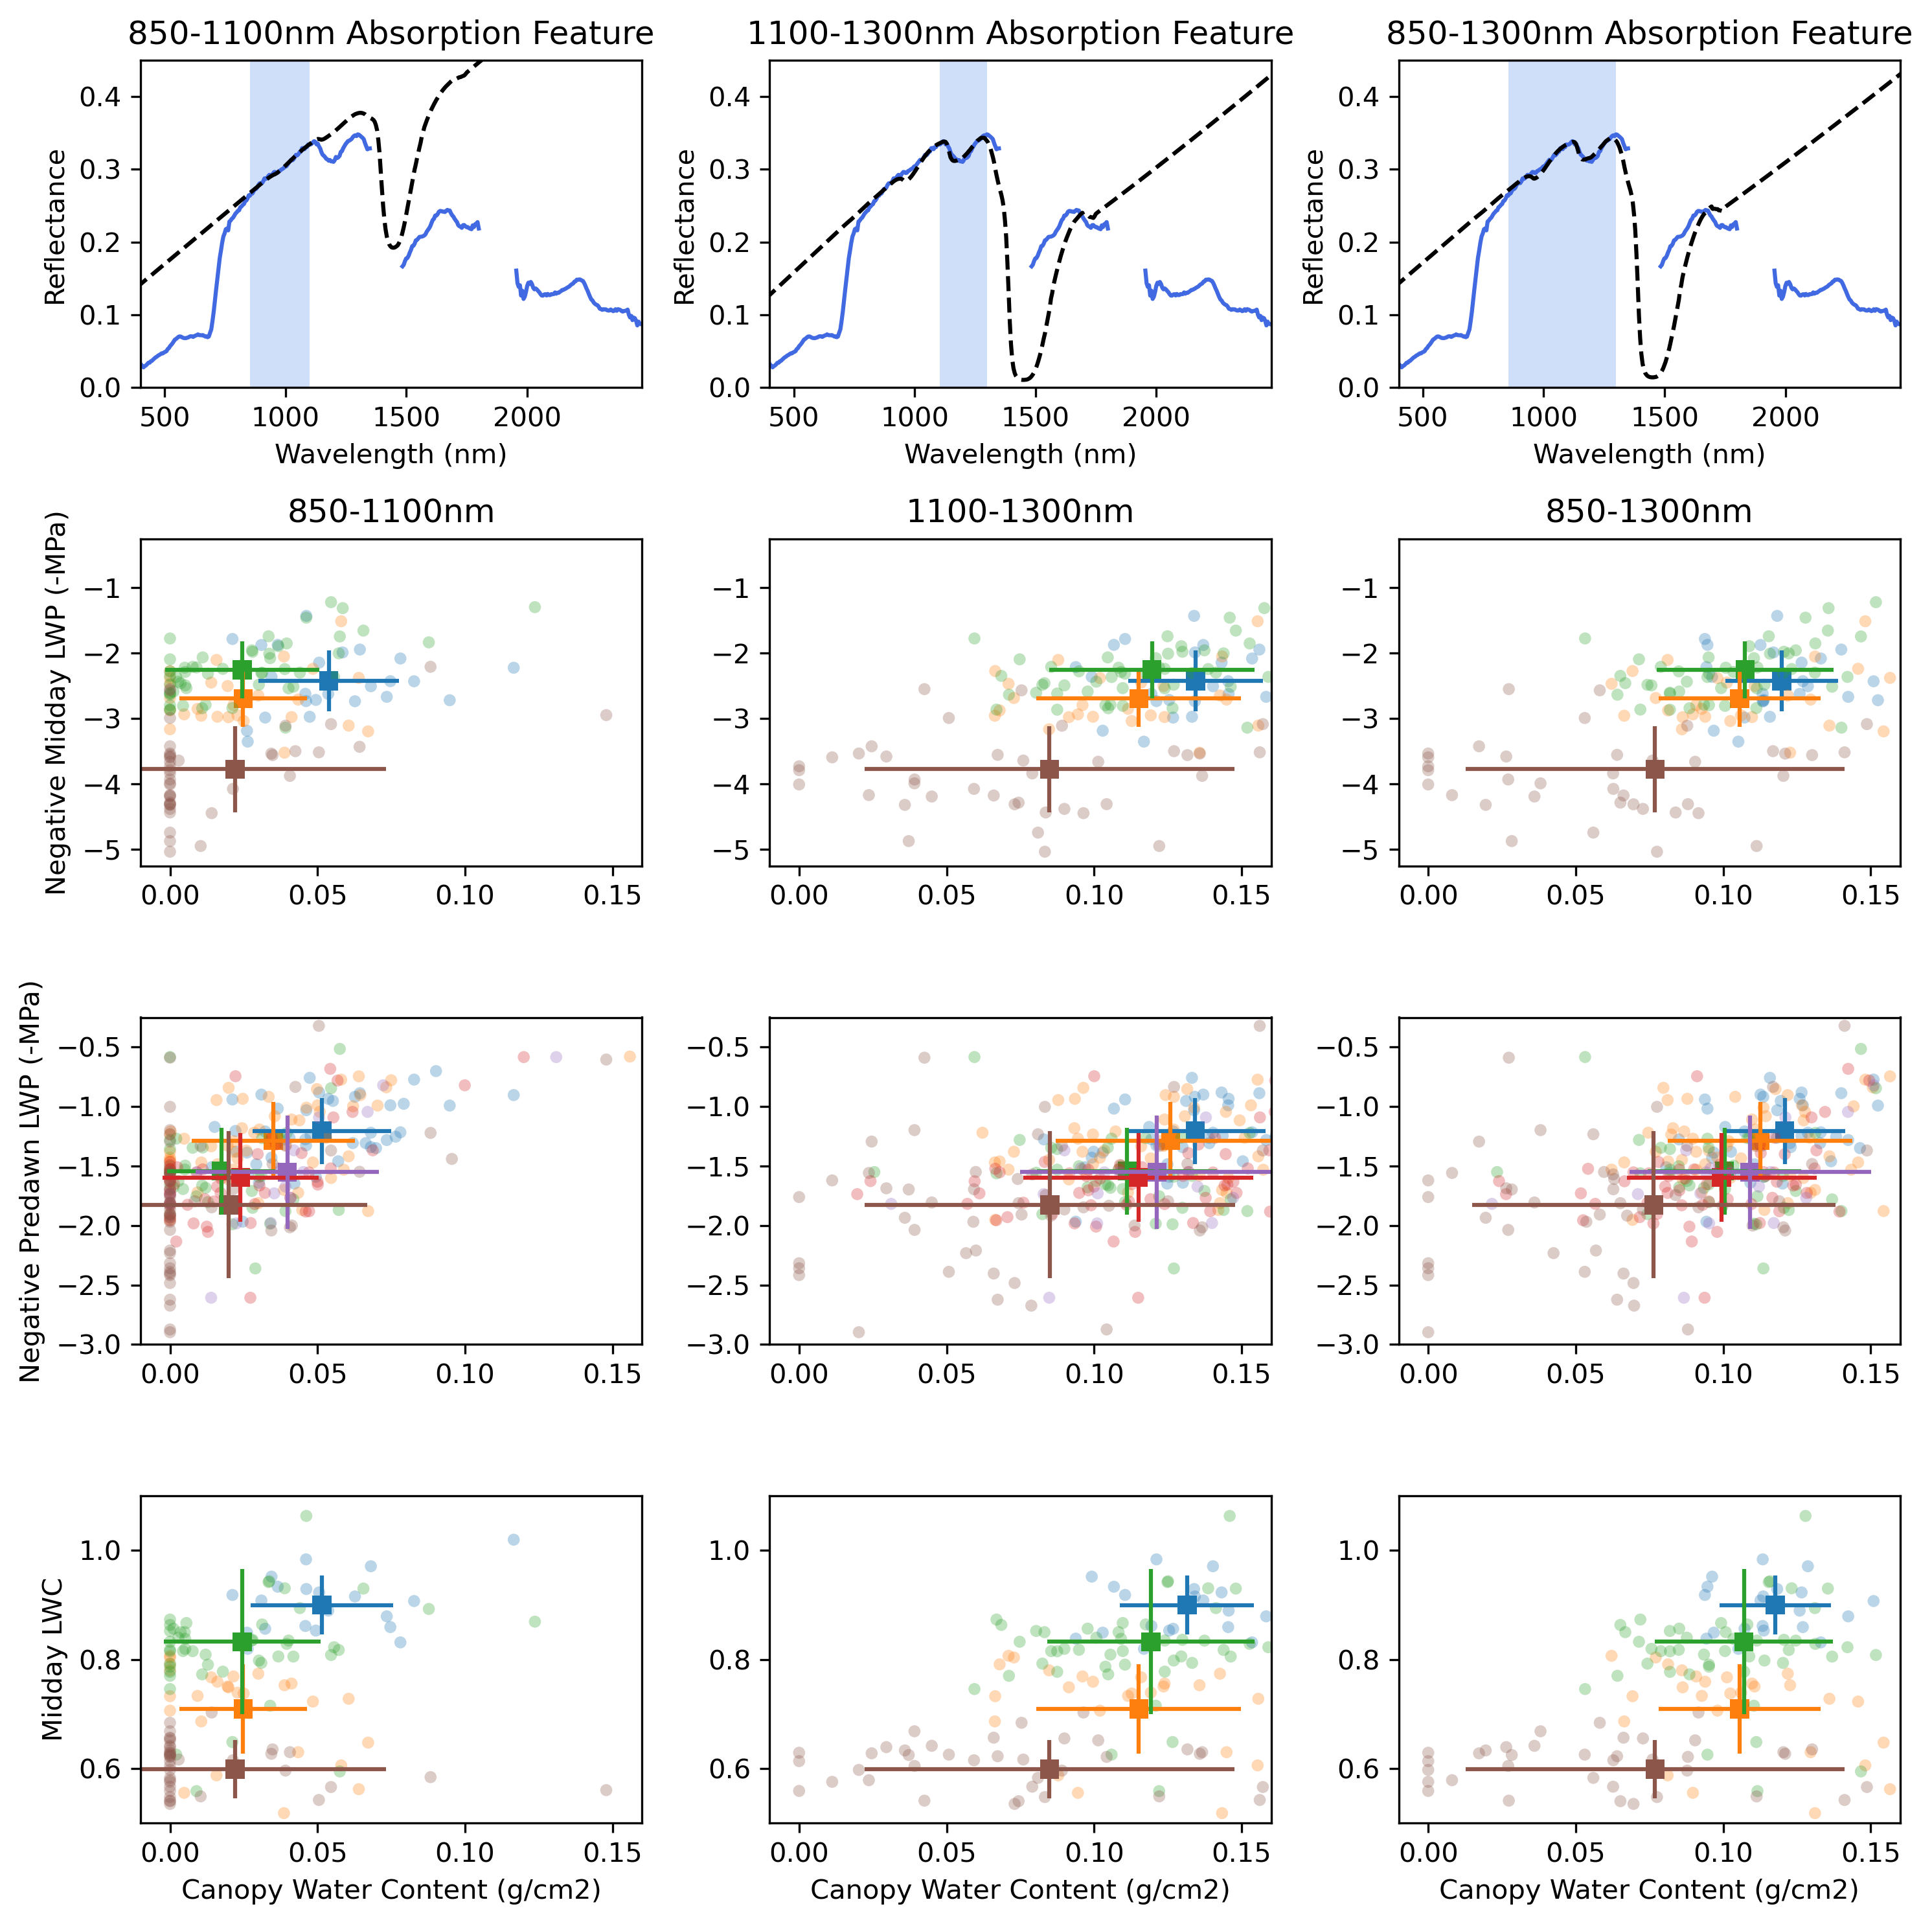

In [17]:
# ALL HAIL THE MEGAPLOT
fig, ([spec1, spec2, spec3], [ax1, ax4, ax7], [ax2, ax5, ax8], [ax3, ax6, ax9]) = plt.subplots(4, 3, figsize=(10, 10))

## example spectra
spec1.plot(wl_nan, spec, label='Reflectance', color='royalblue')
spec1.plot(wavelengths, beer_lambert1, label='Water Absorption', color='black', linestyle='--')
spec1.fill_between(wavelengths, 0, 1, where=np.logical_and(wavelengths > left_bound1, wavelengths < right_bound1), color='cornflowerblue', alpha=0.3, linewidth=0)
spec1.set_xlim(400, 2475)
spec1.set_ylim(0, 0.45)
spec1.set_title('850-1100nm Absorption Feature')
spec1.set_xlabel('Wavelength (nm)')
spec1.set_ylabel('Reflectance')
spec2.plot(wl_nan, spec, label='Reflectance', color='royalblue')
spec2.plot(wavelengths, beer_lambert2, label='Water Absorption', color='black', linestyle='--')
spec2.fill_between(wavelengths, 0, 1, where=np.logical_and(wavelengths > left_bound2, wavelengths < right_bound2), color='cornflowerblue', alpha=0.3, linewidth=0)
spec2.set_xlim(400, 2475)
spec2.set_ylim(0, 0.45)
spec2.set_title('1100-1300nm Absorption Feature')
spec2.set_xlabel('Wavelength (nm)')
spec2.set_ylabel('Reflectance')
spec3.plot(wl_nan, spec, label='Reflectance', color='royalblue')
spec3.plot(wavelengths, beer_lambert3, label='Water Absorption', color='black', linestyle='--')
spec3.fill_between(wavelengths, 0, 1, where=np.logical_and(wavelengths > left_bound3, wavelengths < right_bound3), color='cornflowerblue', alpha=0.3, linewidth=0)
spec3.set_xlim(400, 2475)
spec3.set_ylim(0, 0.45)
spec3.set_title('850-1300nm Absorption Feature')
spec3.set_xlabel('Wavelength (nm)')
spec3.set_ylabel('Reflectance')

## 850-1100nm
for date, cwc_df, color in zip(date_list, cwc_df_list_850_1100, color_list):
    cwc_df_dropna_mdlwp = cwc_df.dropna(subset=['midday_lwp', 'CWC'])
    avg_cwc_mdlwp = cwc_df_dropna_mdlwp['CWC'].mean()
    avg_midday_lwp = cwc_df_dropna_mdlwp['midday_lwp'].mean()
    std_cwc_mdlwp = cwc_df_dropna_mdlwp['CWC'].std()
    std_midday_lwp = cwc_df_dropna_mdlwp['midday_lwp'].std()

    cwc_df_dropna_pdlwp = cwc_df.dropna(subset=['predawn_lwp', 'CWC'])
    avg_cwc_pdlwp = cwc_df_dropna_pdlwp['CWC'].mean()
    avg_predawn_lwp = cwc_df_dropna_pdlwp['predawn_lwp'].mean()
    std_cwc_pdlwp = cwc_df_dropna_pdlwp['CWC'].std()
    std_predawn_lwp = cwc_df_dropna_pdlwp['predawn_lwp'].std()

    cwc_df_dropna_lwc = cwc_df.dropna(subset=['midday_lwc', 'CWC'])
    avg_cwc_lwc = cwc_df_dropna_lwc['CWC'].mean()
    avg_midday_lwc = cwc_df_dropna_lwc['midday_lwc'].mean()
    std_cwc_lwc = cwc_df_dropna_lwc['CWC'].std()
    std_midday_lwc = cwc_df_dropna_lwc['midday_lwc'].std()

    ax1.scatter(cwc_df['CWC'], -1*cwc_df['midday_lwp'], c=color, edgecolors='none', s=20, alpha=0.3, label=date)
    ax1.scatter(avg_cwc_mdlwp, -1*avg_midday_lwp, c=color, edgecolors='none', s=50, alpha=1, marker='s')
    ax1.errorbar(avg_cwc_mdlwp, -1*avg_midday_lwp, yerr=std_midday_lwp, fmt='none', ecolor=color)
    ax1.errorbar(avg_cwc_mdlwp, -1*avg_midday_lwp, xerr=std_cwc_mdlwp, fmt='none', ecolor=color)

    ax2.scatter(cwc_df['CWC'], -1*cwc_df['predawn_lwp'], c=color, edgecolors='none', s=20, alpha=0.3, label=date)
    ax2.scatter(avg_cwc_pdlwp, -1*avg_predawn_lwp, c=color, edgecolors='none', s=50, alpha=1, marker='s')
    ax2.errorbar(avg_cwc_pdlwp, -1*avg_predawn_lwp, yerr=std_predawn_lwp, fmt='none', ecolor=color)
    ax2.errorbar(avg_cwc_pdlwp, -1*avg_predawn_lwp, xerr=std_cwc_pdlwp, fmt='none', ecolor=color)

    ax3.scatter(cwc_df['CWC'], cwc_df['midday_lwc'], c=color, edgecolors='none', s=20, alpha=0.3, label=date)
    ax3.scatter(avg_cwc_lwc, avg_midday_lwc, c=color, edgecolors='none', s=50, alpha=1, marker='s')
    ax3.errorbar(avg_cwc_lwc, avg_midday_lwc, yerr=std_midday_lwc, fmt='none', ecolor=color)
    ax3.errorbar(avg_cwc_lwc, avg_midday_lwc, xerr=std_cwc_lwc, fmt='none', ecolor=color)

ax1.set_ylabel('Negative Midday LWP (-MPa)')
# ax1.set_xlabel('Canopy Water Content (g/cm2)')
ax1.set_title('850-1100nm')
ax1.set_xlim(-0.01, 0.16)
ax1.set_ylim(-5.25, -0.25)

ax2.set_ylabel('Negative Predawn LWP (-MPa)')
# ax2.set_xlabel('Canopy Water Content (g/cm2)')
# ax2.set_title('Predawn LWP vs CWC')
ax2.set_xlim(-0.01, 0.16)
ax2.set_ylim(-3, -0.25)

ax3.set_ylabel('Midday LWC')
ax3.set_xlabel('Canopy Water Content (g/cm2)')
# ax3.set_title('Midday LWC vs CWC')
ax3.set_xlim(-0.01, 0.16)
ax3.set_ylim(0.5, 1.1)


## 1100-1300nm
for date, cwc_df, color in zip(date_list, cwc_df_list_1100_1300, color_list):
    cwc_df_dropna_mdlwp = cwc_df.dropna(subset=['midday_lwp', 'CWC'])
    avg_cwc_mdlwp = cwc_df_dropna_mdlwp['CWC'].mean()
    avg_midday_lwp = cwc_df_dropna_mdlwp['midday_lwp'].mean()
    std_cwc_mdlwp = cwc_df_dropna_mdlwp['CWC'].std()
    std_midday_lwp = cwc_df_dropna_mdlwp['midday_lwp'].std()

    cwc_df_dropna_pdlwp = cwc_df.dropna(subset=['predawn_lwp', 'CWC'])
    avg_cwc_pdlwp = cwc_df_dropna_pdlwp['CWC'].mean()
    avg_predawn_lwp = cwc_df_dropna_pdlwp['predawn_lwp'].mean()
    std_cwc_pdlwp = cwc_df_dropna_pdlwp['CWC'].std()
    std_predawn_lwp = cwc_df_dropna_pdlwp['predawn_lwp'].std()

    cwc_df_dropna_lwc = cwc_df.dropna(subset=['midday_lwc', 'CWC'])
    avg_cwc_lwc = cwc_df_dropna_lwc['CWC'].mean()
    avg_midday_lwc = cwc_df_dropna_lwc['midday_lwc'].mean()
    std_cwc_lwc = cwc_df_dropna_lwc['CWC'].std()
    std_midday_lwc = cwc_df_dropna_lwc['midday_lwc'].std()

    ax4.scatter(cwc_df['CWC'], -1*cwc_df['midday_lwp'], c=color, edgecolors='none', s=20, alpha=0.3, label=date)
    ax4.scatter(avg_cwc_mdlwp, -1*avg_midday_lwp, c=color, edgecolors='none', s=50, alpha=1, marker='s')
    ax4.errorbar(avg_cwc_mdlwp, -1*avg_midday_lwp, yerr=std_midday_lwp, fmt='none', ecolor=color)
    ax4.errorbar(avg_cwc_mdlwp, -1*avg_midday_lwp, xerr=std_cwc_mdlwp, fmt='none', ecolor=color)

    ax5.scatter(cwc_df['CWC'], -1*cwc_df['predawn_lwp'], c=color, edgecolors='none', s=20, alpha=0.3, label=date)
    ax5.scatter(avg_cwc_pdlwp, -1*avg_predawn_lwp, c=color, edgecolors='none', s=50, alpha=1, marker='s')
    ax5.errorbar(avg_cwc_pdlwp, -1*avg_predawn_lwp, yerr=std_predawn_lwp, fmt='none', ecolor=color)
    ax5.errorbar(avg_cwc_pdlwp, -1*avg_predawn_lwp, xerr=std_cwc_pdlwp, fmt='none', ecolor=color)

    ax6.scatter(cwc_df['CWC'], cwc_df['midday_lwc'], c=color, edgecolors='none', s=20, alpha=0.3, label=date)
    ax6.scatter(avg_cwc_lwc, avg_midday_lwc, c=color, edgecolors='none', s=50, alpha=1, marker='s')
    ax6.errorbar(avg_cwc_lwc, avg_midday_lwc, yerr=std_midday_lwc, fmt='none', ecolor=color)
    ax6.errorbar(avg_cwc_lwc, avg_midday_lwc, xerr=std_cwc_lwc, fmt='none', ecolor=color)

# ax4.set_ylabel('Negative Midday LWP (-MPa)')
# ax4.set_xlabel('Canopy Water Content (g/cm2)')
ax4.set_title('1100-1300nm')
ax4.set_xlim(-0.01, 0.16)
ax4.set_ylim(-5.25, -0.25)

# ax5.set_ylabel('Negative Predawn LWP (-MPa)')
# ax5.set_xlabel('Canopy Water Content (g/cm2)')
# ax5.set_title('Predawn LWP vs CWC')
ax5.set_xlim(-0.01, 0.16)
ax5.set_ylim(-3, -0.25)

# ax6.set_ylabel('Midday LWC')
ax6.set_xlabel('Canopy Water Content (g/cm2)')
# ax6.set_title('Midday LWC vs CWC')
ax6.set_xlim(-0.01, 0.16)
ax6.set_ylim(0.5, 1.1)


## 850-1300nm
for date, cwc_df, color in zip(date_list, cwc_df_list_850_1300, color_list):
    cwc_df_dropna_mdlwp = cwc_df.dropna(subset=['midday_lwp', 'CWC'])
    avg_cwc_mdlwp = cwc_df_dropna_mdlwp['CWC'].mean()
    avg_midday_lwp = cwc_df_dropna_mdlwp['midday_lwp'].mean()
    std_cwc_mdlwp = cwc_df_dropna_mdlwp['CWC'].std()
    std_midday_lwp = cwc_df_dropna_mdlwp['midday_lwp'].std()

    cwc_df_dropna_pdlwp = cwc_df.dropna(subset=['predawn_lwp', 'CWC'])
    avg_cwc_pdlwp = cwc_df_dropna_pdlwp['CWC'].mean()
    avg_predawn_lwp = cwc_df_dropna_pdlwp['predawn_lwp'].mean()
    std_cwc_pdlwp = cwc_df_dropna_pdlwp['CWC'].std()
    std_predawn_lwp = cwc_df_dropna_pdlwp['predawn_lwp'].std()

    cwc_df_dropna_lwc = cwc_df.dropna(subset=['midday_lwc', 'CWC'])
    avg_cwc_lwc = cwc_df_dropna_lwc['CWC'].mean()
    avg_midday_lwc = cwc_df_dropna_lwc['midday_lwc'].mean()
    std_cwc_lwc = cwc_df_dropna_lwc['CWC'].std()
    std_midday_lwc = cwc_df_dropna_lwc['midday_lwc'].std()

    ax7.scatter(cwc_df['CWC'], -1*cwc_df['midday_lwp'], c=color, edgecolors='none', s=20, alpha=0.3, label=date)
    ax7.scatter(avg_cwc_mdlwp, -1*avg_midday_lwp, c=color, edgecolors='none', s=50, alpha=1, marker='s')
    ax7.errorbar(avg_cwc_mdlwp, -1*avg_midday_lwp, yerr=std_midday_lwp, fmt='none', ecolor=color)
    ax7.errorbar(avg_cwc_mdlwp, -1*avg_midday_lwp, xerr=std_cwc_mdlwp, fmt='none', ecolor=color)

    ax8.scatter(cwc_df['CWC'], -1*cwc_df['predawn_lwp'], c=color, edgecolors='none', s=20, alpha=0.3, label=date)
    ax8.scatter(avg_cwc_pdlwp, -1*avg_predawn_lwp, c=color, edgecolors='none', s=50, alpha=1, marker='s')
    ax8.errorbar(avg_cwc_pdlwp, -1*avg_predawn_lwp, yerr=std_predawn_lwp, fmt='none', ecolor=color)
    ax8.errorbar(avg_cwc_pdlwp, -1*avg_predawn_lwp, xerr=std_cwc_pdlwp, fmt='none', ecolor=color)

    ax9.scatter(cwc_df['CWC'], cwc_df['midday_lwc'], c=color, edgecolors='none', s=20, alpha=0.3, label=date)
    ax9.scatter(avg_cwc_lwc, avg_midday_lwc, c=color, edgecolors='none', s=50, alpha=1, marker='s')
    ax9.errorbar(avg_cwc_lwc, avg_midday_lwc, yerr=std_midday_lwc, fmt='none', ecolor=color)
    ax9.errorbar(avg_cwc_lwc, avg_midday_lwc, xerr=std_cwc_lwc, fmt='none', ecolor=color)

# ax7.set_ylabel('Negative Midday LWP (-MPa)')
# ax7.set_xlabel('Canopy Water Content (g/cm2)')
ax7.set_title('850-1300nm')
ax7.set_xlim(-0.01, 0.16)
ax7.set_ylim(-5.25, -0.25)

# ax8.set_ylabel('Negative Predawn LWP (-MPa)')
# ax8.set_xlabel('Canopy Water Content (g/cm2)')
# ax8.set_title('Predawn LWP vs CWC')
ax8.set_xlim(-0.01, 0.16)
ax8.set_ylim(-3, -0.25)

# ax9.set_ylabel('Midday LWC')
ax9.set_xlabel('Canopy Water Content (g/cm2)')
# ax9.set_title('Midday LWC vs CWC')
ax9.set_xlim(-0.01, 0.16)
ax9.set_ylim(0.5, 1.1)

plt.tight_layout()
plt.savefig('./megaplot_with_specs.png')